imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json

2024-11-04 03:09:57.655231: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Helper and preprocessing functions

In [2]:
def tf_scale_imgs(imgs, scale_factor):
    return imgs * scale_factor + 0.5 * (1 - scale_factor) * tf.ones(imgs.shape)


def tf_scale_labels(labels, scale_factor):
    return labels * scale_factor + 0.5 * (1 - scale_factor) * tf.ones(labels.shape)


def tf_f_inv(x, act_fn):
    """ (activation_size, batch_size) """
    if act_fn == "LINEAR":
        m = x
    elif act_fn == "TANH":
        num = tf.ones_like(x) + x
        div = tf.ones_like(x) - x + 1e-7
        m = 0.5 * tf.math.log(num / div)
    elif act_fn == "LOGSIG":
        div = tf.ones_like(x) - x + 1e-7
        m = tf.math.log((x / div) + 1e-7)
    else:
        raise ValueError(f"{act_fn} not supported")
    return m


def img_preproc(x, y, dtype=tf.float32): 
  """Cast input image to a certain tf dtype and normalize them between 0 and 1."""
  x = tf.cast(x, dtype) / 255.
  #x = tf_scale_imgs(x, cf.img_scale)
  #y = tf_scale_labels(y, cf.label_scale)
  #x = tf_f_inv(x, "TANH")
  #y = tf.one_hot(y, depth=10)
  return x, y


def flatten(x, y):  
  #flattens a video image series (or batch of images) to (n_batch, n_steps, 1) d.
  shape = tf.shape(x)
  if len(shape) == 5: # hack, determining if it's a video or not (batch_size, n_steps, height, width, channels)
    x = tf.reshape(x, [shape[0], shape[1], -1])
  elif len(shape) == 4: # regular image (batch_size, height, width, channels)
    x = tf.reshape(x, [shape[0], -1])
  return x, y

def augment_images(batch_images, batch_labels):
    """
    Applies data augmentation on a batch of images without TensorFlow Addons.
    
    Parameters:
    batch_images: Tensor of shape (n_batch, 56, 28, 3)
    
    Returns:
    Augmented batch of images.
    """
    # Random horizontal flip
    augmented_images = tf.image.random_flip_left_right(batch_images)
    
    # Random brightness adjustment
    augmented_images = tf.image.random_brightness(augmented_images, max_delta=0.1)
    
    # Random contrast adjustment
    augmented_images = tf.image.random_contrast(augmented_images, lower=0.9, upper=1.1)
    
    # Random saturation adjustment
    augmented_images = tf.image.random_saturation(augmented_images, lower=0.9, upper=1.1)
    
    # Random hue adjustment
    augmented_images = tf.image.random_hue(augmented_images, max_delta=0.05)
    
    # Clipping to ensure pixel values are valid after transformations
    augmented_images = tf.clip_by_value(augmented_images, 0.0, 1.0)
    
    return augmented_images, batch_labels


In [3]:
resultspath = '/Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_{epoch:02d}_{accuracy:.2f}.keras'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= resultspath,  
    monitor='accuracy',         # The metric to monitor for saving (e.g., 'val_loss', 'val_accuracy')
    save_best_only=False,        # Save only the best model 
    save_weights_only=False,    # False = Save the entire model; True = only save weights
    mode='max',                 # Set to 'min' for metrics like loss and 'max' for metrics like accuracy
    save_freq='epoch',          # Frequency of saving, e.g., epoch or batch 
    verbose=1                   # Print when saving a model
)


build the network

In [4]:
class CustomDense(tf.keras.layers.Dense):
    def call(self, inputs):
        """This works like a dense, except for the activation being called earlier."""
        # Apply the activation to the input first
        activated_input = self.activation(inputs)
        # Perform the matrix multiplication and add the bias
        output = tf.matmul(activated_input, self.kernel)
        if self.use_bias:
            output = output + self.bias
        return output


class PredictiveCodingNetwork(tf.keras.Sequential):
    def __init__(self, layers, vars, beta, **kwargs):
        """Initialize a PredictiveCodingNetwork"""
        super().__init__(layers, **kwargs)
        self.vars = tf.convert_to_tensor(vars, dtype=tf.float32)
        self.beta = beta

    def call_with_states(self, x):
        x_list = [x]
        for layer in self.layers:
            x = layer(x)
            x_list.append(x)
        return x_list

    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        # do the stuff we do in train_epochs
        outputs, errors = self.infer(x, y)
        self.update_params(outputs, errors)

        # Update metrics (includes the metric that tracks the loss)
        pred = self.call(x)
        for metric in self.metrics:
            metric.update_state(y, pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
    
   
    def infer(self, x_batch, y_batch=None, n_iter=50, return_sequence=False):
        """Note: while model call, call with states and model evaluate take
        2D input, train_step and infer take stacked 3D inputs."""
        if return_sequence:
            errors_time = []
            states_time = []
        errors = [None for _ in range(len(self.layers))]
        f_x_arr = [None for _ in range(len(self.layers))]
        f_x_deriv_arr = [None for _ in range(len(self.layers))]
        shape = x_batch.shape
        batch_size = shape[0]

        for itr in range(n_iter):
            # if its the first itr, set x to the current forward call
            if itr == 0:
                x = self.call_with_states(x_batch)

                if y_batch is not None:
                  x[-1] = y_batch
            else:
                # update g and x only for consecutive iterations
                for l in range(1, len(self.layers)):
                    g = tf.multiply(tf.matmul(errors[l], self.layers[l].kernel, transpose_b=True), f_x_deriv_arr[l])
                    x[l] = x[l] + self.beta * (-errors[l-1] + g)

            # update f_x etc for every iteration
            for l in range(len(self.layers)):
                f_x = self.layers[l].activation(x[l])
                f_x_deriv_fn = self.get_activation_derivative(self.layers[l].activation)
                f_x_deriv = f_x_deriv_fn(x[l])
                f_x_arr[l] = f_x
                f_x_deriv_arr[l] = f_x_deriv
                errors[l] = (x[l + 1] - tf.matmul(f_x, self.layers[l].kernel) - self.layers[l].bias) / self.vars[l]
            
            if return_sequence:
                errors_time.append(errors)
                states_time.append(x)

        # return what we want to return
        if return_sequence:
            states_time = [tf.stack(tensors, axis=1) for tensors in zip(*states_time)]
            errors_time = [tf.stack(tensors, axis=1) for tensors in zip(*errors_time)]
            return states_time, errors_time
        else:
            return x, errors
    
    # We need to check if we actually need call here.
    # Now, call will give us the result of the network after the first inference step
    # If we want to have the results after the last inference step, we would need to change this
    #def call(self, inputs, training=False):
    #    """Call, but time distributed."""
    #    x, errors = self.infer(inputs, return_sequence=False)
    #    return x[-1]

    def update_params(self, x, errors):
        """Update the model parameters."""
        batch_size = tf.cast(tf.shape(x[0])[0], tf.float32)
        gradients = []
        for l, layer in enumerate(self.layers):
            grad_w = self.vars[-1] * (1 / batch_size) * tf.matmul(tf.transpose(self.layers[l].activation(x[l])), errors[l])
            grad_b = self.vars[-1] * (1 / batch_size) * tf.reduce_sum(errors[l], axis=0)
            gradients.append((-grad_w, layer.kernel))
            gradients.append((-grad_b, layer.bias))
        self.optimizer.apply_gradients(gradients)

    def get_activation_derivative(self, activation):
        """Return a function for the derivative of the given activation function."""
        activation_fn = tf.keras.activations.get(activation)
        if activation_fn == tf.keras.activations.linear:
            return lambda x: tf.ones_like(x)
        elif activation_fn == tf.keras.activations.tanh:
            return lambda x: 1 - tf.square(tf.nn.tanh(x))
        elif activation_fn == tf.keras.activations.sigmoid:
            return lambda x: tf.nn.sigmoid(x) * (1 - tf.nn.sigmoid(x))
        else:
            raise ValueError(f"{activation} not supported")

Load the data

In [5]:
# Image paths 

img_dir_lead = '/Users/denisekittelmann/Documents/Python/BiMoL/data/Leading/'
img_dir_trail = '/Users/denisekittelmann/Documents/Python/BiMoL/data/Trailing/'
img_dir_test_lead = '/Users/denisekittelmann/Documents/Python/BiMoL/data/Test/Test_Leading/'
img_dir_test_trail = '/Users/denisekittelmann/Documents/Python/BiMoL/data/Test/Test_Trailing/'
class_names_L = ['barn', 'beach', 'cave', 'library', 'restaurant']
class_names_T = ['castle', 'Church', 'conference_room', 'forest'] # changed the order 
batch_size = None # adjust if needed, e.g., 32
image_size = (28,28)
validation_split = 0.1
seed = 123

In [15]:
# Image paths 

img_dir_lead = '/scratch/guetlid95/datasets/mcdermott_2024/Stimuli_2/Leading/'
img_dir_trail = '/scratch/guetlid95/datasets/mcdermott_2024/Stimuli_2/Trailing/' 
img_dir_test_lead = '/scratch/guetlid95/datasets/mcdermott_2024/Stimuli_2/Test/Test_Leading/' 
img_dir_test_trail = '/scratch/guetlid95/datasets/mcdermott_2024/Stimuli_2/Test/Test_Trailing/' 
class_names_L = ['barn', 'beach', 'cave', 'library', 'restaurant']
class_names_T = ['castle', 'Church', 'conference_room', 'forest'] # changed the order 
batch_size = 32
image_size = (28,28)
validation_split = 0.1
seed = 123

In [6]:
# Create a dict that assigns the correct labels for each leading-trailing imgage pair

"""
L1 = barn = label 0 - cat 1
L2 = beach = label 1 - cat 2
L5 = cave = label 2 - cat 3
L3 = library = label - cat 4
L4 = restaurant = label 4 - cat 5


L1 = barn = label 0 
L2 = beach = label 1
L3 = cave = label 2
L4 = library = label 3
L5 = restaurant = label 4 

    % Map 1 = C1 LEADING >> C6 TRAILING valid, C7 invalid
    % Map 2 = C2 LEADING >> C6 TRAILING valid, C7 invalid
    % Map 3 = C4 LEADING >> C7 TRAILING valid, C6 invalid
    % Map 4 = C5 LEADING >> C7 TRAILING valid, C6 invalid
    % Map 5 = C3 LEADING >> C8 OR C9 TRAILING
    % Map 6 = C3 LEADING >> C9 OR C9 TRAILING


T6 = Church = label 1   
T7 = conference room = label 2
T8 = castle = label 0   
T9 = forest = label 3

MAPPING:

L1 -> T6 = 0.75 -> (0,1) 
L1 -> T7 = 0.25 -> (0,2)
L1 -> T8 = 0 -> (0,0)
L1 -> T9 = 0 -> (0,3)

L2 -> T6 = 0.75 -> (1,1) 
L2 -> T7 = 0.25 -> (1,2)
L2 -> T8 = 0 -> (1,0)
L2 -> T9 = 0 -> (1,3)

L3 -> T6 = 0 -> (3,1) 
L3 -> T7 = 0 -> (3,2)
L3 -> T8 = 0.5 -> (3,0)
L3 -> T9 = 0.5 -> (3,3)

L4 -> T6 = 0.25 -> (4,1) 
L4 -> T7 = 0.75 -> (4,2)
L4 -> T8 = 0 -> (4,0)
L4 -> T9 = 0 -> (4,3)

L5 -> T6 = 0.25 -> (2,1) 
L5 -> T7 = 0.75 -> (2,2)
L5 -> T8 = 0 -> (2,0)
L5 -> T9 = 0 -> (2,3)

"""


label_dict = {
    (0, 1): 0.0,
    (0, 2): 0.75,
    (0, 0): 0.25,
    (0, 3): 0.25,
    
    (1, 1): 0.0,
    (1, 2): 0.75,
    (1, 0): 0.25,
    (1, 3): 0.25,
    
    (3, 1): 0.75,
    (3, 2): 0.75,
    (3, 0): 0.50,
    (3, 3): 0.50,
    
    (4, 1): 0.75,
    (4, 2): 0.0,
    (4, 0): 0.25,
    (4, 3): 0.25,
    
    (2, 1): 0.75, 
    (2, 2): 0.0,
    (2, 0): 0.25,
    (2, 3): 0.25
}


In [7]:
# Generate image pairs 
def img_sequence(img_t1, img_t2, label_t1, label_t2, label_dict): 
    """This function stacks two images to construct an image pair and assigns a single label based on the label dictionary."""
    
    img_t1 = tf.cast(img_t1, dtype=tf.float32)
    img_t2 = tf.cast(img_t2, dtype=tf.float32)
    
    x = tf.concat([img_t1, img_t2], axis=0) 

    key_t1 = int(label_t1.numpy())
    key_t2 = int(label_t2.numpy())
 
    
    if (key_t1, key_t2) in label_dict:
        label = label_dict[(key_t1, key_t2)]
        #print(f"Label value found: {label}")
    else:
        print(f"Label pair {(key_t1, key_t2)} not found.")

    
    y = tf.cast(tf.random.uniform([]) < label, tf.float32)
    y = tf.expand_dims(y, axis=0)  
    
    return x,y


In [8]:
def generate_dataset(img_dirt1, img_dirt2, class_namest1, class_namest2, label_dict, image_size = None, seed = None, shuffle = False):       
    
    
    data_t1 = tf.keras.preprocessing.image_dataset_from_directory(
        img_dirt1, 
        label_mode = 'int',
        class_names= class_namest1,
        batch_size = None,
        color_mode = 'rgb',
        image_size = image_size, 
        #shuffle = True, 
        seed = seed
        )

    data_t2 = tf.keras.preprocessing.image_dataset_from_directory(
        img_dirt2, 
        label_mode = 'int',
        class_names= class_namest2,
        batch_size = None,
        color_mode = 'rgb', 
        image_size = image_size, 
        #shuffle = True, 
        seed = seed
    )
    
    if shuffle:
        data_t1.shuffle(99999, seed = seed*2)
        data_t2.shuffle(99999, seed = seed*3)
    
    # iterate through shuffled leading and trailing datasets
    leading = iter(data_t1)
    trailing = iter(data_t2) 
              
    while True:
        try:
            # Retrieve single samples
            img_t1, label_t1 = next(leading)
            img_t2, label_t2 = next(trailing)

            # Generate x, y pairs for single samples
            x, y = img_sequence(img_t1, img_t2, label_t1, label_t2, label_dict) 
            yield x, y
            
        except StopIteration:
            # Break the loop if no more samples
            break
        
        

In [9]:
# Build the validation dataset

seed = 123

val_dataset = tf.data.Dataset.from_generator(
    lambda: generate_dataset(img_dir_test_lead, img_dir_test_trail, class_names_L, class_names_T, label_dict, image_size = (28,28), seed = seed),
    output_signature=(
        tf.TensorSpec(shape=(56, 28, 3), dtype=tf.float32),  # shape of x 
        tf.TensorSpec(shape=(1), dtype=tf.float32)  # shape of y 
    )
) 

print(val_dataset)


<_FlatMapDataset element_spec=(TensorSpec(shape=(56, 28, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.float32, name=None))>


In [10]:
from collections import Counter

def check_transition_balance(dataset):
    transition_counts = Counter()
    
    # Use as_numpy_iterator to extract data from the dataset
    for image, label in dataset.as_numpy_iterator():
        
        transition_counts[label[0]] += 1  # Assuming label is a scalar or one-element array
    
    print("Transition frequencies:")
    for transition, count in transition_counts.items():
        print(f"Transition {transition}: {count} occurrences")


In [11]:
# define the model
model = PredictiveCodingNetwork([CustomDense(units=6, activation="sigmoid"),
                                 CustomDense(units=4, activation="sigmoid"), 
                                 CustomDense(units=1, activation="sigmoid")], 
                                vars=[1, 1, 1], # variances. This is super useless and in the code only the last variance is used
                                beta=0.1)

model.build([None, 4704]) 
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-7, weight_decay=1e-2), # wd only when overfitting occurs, lr  
              metrics= ["accuracy"],  
              loss="CategoricalCrossentropy",  # This is just a sham loss we need so model.evaluate doesn't throw an error. We don't use it.
              )

# save model before training
model.save('/Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/final_model_pcn_lr1e-7_untrained.keras') 

# evaluate accuracy and train model
loss, accuracy = model.evaluate(val_dataset.batch(512).map(img_preproc).map(flatten)) 
print(f"Accuracy before training: {accuracy}")


n_epochs = 1000 

train_acc = []
val_acc = []
train_loss = []
val_loss = []
histories = []

for i in range(n_epochs): 
    
    resultspath = f'/Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_{i:02d}_{{accuracy:.2f}}.keras'

    print(f"Epoch {i + 1}/{n_epochs}") 
    
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= resultspath,  
    monitor='accuracy',         # The metric to monitor for saving (e.g., 'val_loss', 'val_accuracy')
    save_best_only=False,        # Save only the best model 
    save_weights_only=False,    # False = Save the entire model; True = only save weights
    mode='max',                 # Set to 'min' for metrics like loss and 'max' for metrics like accuracy
    save_freq='epoch',          # Frequency of saving, e.g., epoch or batch 
    verbose=1                   # Print when saving a model
    )
    
    train_dataset = tf.data.Dataset.from_generator(
        lambda: generate_dataset(img_dir_lead, img_dir_trail, class_names_L, class_names_T, label_dict, image_size = (28,28), seed = i, shuffle = True),
        output_signature=(
            tf.TensorSpec(shape=(56, 28, 3), dtype=tf.float32),  # shape of x 
            tf.TensorSpec(shape=(1), dtype=tf.float32)  # shape of y 
        )
    ) 

    check_transition_balance(train_dataset)
    
    history = model.fit(train_dataset.shuffle(99999).batch(512).map(img_preproc).map(augment_images).map(flatten), 
            validation_data=val_dataset.batch(512).map(img_preproc).map(flatten),
            callbacks=[checkpoint_callback]) 
    
    
    train_acc.extend(history.history['accuracy'])
    val_acc.extend(history.history['val_accuracy'])
    train_loss.extend(history.history['loss'])
    val_loss.extend(history.history['val_loss'])
    
    epoch_history = {
        "epoch": i + 1,
        "history": history.history
    }
    
    histories.append(epoch_history)


    with open('/Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/all_epochs_history.json', 'w') as f:
        json.dump(histories, f)


loss, accuracy = model.evaluate(val_dataset.batch(512).map(img_preproc).map(flatten)) 
print(f"Accuracy after training: {accuracy}")

model.save('/Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/final_model_pcn_lr1e-7_trained.keras')

/Users/denisekittelmann/miniconda3/envs/BiMo_3.9/lib/python3.9/site-packages/keras/src/losses/losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.


2024-11-04 03:21:38.910062: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6389 - loss: 4.3048e-08
Accuracy before training: 0.6388888955116272
Epoch 1/1000


2024-11-04 03:21:39.119583: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/denisekittelmann/miniconda3/envs/BiMo_3.9/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.


2024-11-04 03:21:43.245988: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Transition frequencies:
Transition 0.0: 1066 occurrences
Transition 1.0: 550 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 10s 57ms/step - accuracy: 0.6865 - loss: 0.3136Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_00_0.67.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 232ms/step - accuracy: 0.6780 - loss: 0.3221 - val_accuracy: 0.6944 - val_loss: 3.6425e-08


2024-11-04 03:21:53.971871: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 2/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 0.0: 1074 occurrences
Transition 1.0: 542 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 4s 59ms/step - accuracy: 0.6701 - loss: 0.3298Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_01_0.67.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.6682 - loss: 0.3318 - val_accuracy: 0.7167 - val_loss: 3.3776e-08
Epoch 3/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.


2024-11-04 03:22:08.473338: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Transition frequencies:
Transition 1.0: 525 occurrences
Transition 0.0: 1091 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 4s 59ms/step - accuracy: 0.6640 - loss: 0.3363Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_02_0.67.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 249ms/step - accuracy: 0.6657 - loss: 0.3345 - val_accuracy: 0.6611 - val_loss: 4.0399e-08
Epoch 4/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 1.0: 534 occurrences
Transition 0.0: 1082 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 5s 96ms/step - accuracy: 0.6485 - loss: 0.3515Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users

2024-11-04 03:22:33.705699: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 0.0: 1080 occurrences
Transition 1.0: 536 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 56ms/step - accuracy: 0.6736 - loss: 0.3263Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_05_0.67.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 216ms/step - accuracy: 0.6710 - loss: 0.3289 - val_accuracy: 0.6889 - val_loss: 3.7087e-08
Epoch 7/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 0.0: 1081 occurrences
Transition 1.0: 535 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 45ms/step - accuracy: 0.6746 - loss: 0.3255Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 

2024-11-04 03:23:25.520049: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Transition frequencies:
Transition 1.0: 537 occurrences
Transition 0.0: 1079 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 5s 61ms/step - accuracy: 0.6829 - loss: 0.3172Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_10_0.67.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 289ms/step - accuracy: 0.6783 - loss: 0.3217 - val_accuracy: 0.6556 - val_loss: 4.1061e-08
Epoch 12/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 0.0: 1083 occurrences
Transition 1.0: 533 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      4/Unknown 6s 100ms/step - accuracy: 0.6674 - loss: 0.3328Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Use

2024-11-04 03:25:18.566049: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 0.0: 1087 occurrences
Transition 1.0: 529 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 51ms/step - accuracy: 0.6737 - loss: 0.3261Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_21_0.67.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - accuracy: 0.6725 - loss: 0.3273 - val_accuracy: 0.6833 - val_loss: 3.7750e-08
Epoch 23/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 1.0: 536 occurrences
Transition 0.0: 1080 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 64ms/step - accuracy: 0.6713 - loss: 0.3287Found 180 files belonging to 5 classes.
Found 180 files belonging to 4

2024-11-04 03:28:19.122417: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Transition frequencies:
Transition 0.0: 1062 occurrences
Transition 1.0: 554 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 59ms/step - accuracy: 0.6589 - loss: 0.3412Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_42_0.66.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - accuracy: 0.6594 - loss: 0.3406 - val_accuracy: 0.7333 - val_loss: 3.1789e-08
Epoch 44/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 1.0: 537 occurrences
Transition 0.0: 1079 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      4/Unknown 3s 38ms/step - accuracy: 0.6680 - loss: 0.3320Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /User

2024-11-04 03:34:00.063196: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 0.0: 1078 occurrences
Transition 1.0: 538 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 47ms/step - accuracy: 0.6542 - loss: 0.3459Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_85_0.66.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - accuracy: 0.6556 - loss: 0.3444 - val_accuracy: 0.6833 - val_loss: 3.7750e-08
Epoch 87/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 0.0: 1069 occurrences
Transition 1.0: 547 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 47ms/step - accuracy: 0.7043 - loss: 0.2958Found 180 files belonging to 5 classes.
Found 180 files belonging to 4

2024-11-04 03:45:11.831270: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Transition frequencies:
Transition 0.0: 1096 occurrences
Transition 1.0: 520 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 48ms/step - accuracy: 0.6631 - loss: 0.3370Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_170_0.67.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - accuracy: 0.6644 - loss: 0.3357 - val_accuracy: 0.6722 - val_loss: 3.9074e-08
Epoch 172/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 1.0: 515 occurrences
Transition 0.0: 1101 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 55ms/step - accuracy: 0.6676 - loss: 0.3323Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Us

2024-11-04 04:08:10.682992: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 0.0: 1098 occurrences
Transition 1.0: 518 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      4/Unknown 3s 36ms/step - accuracy: 0.6745 - loss: 0.3258Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_341_0.67.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 0.6736 - loss: 0.3266 - val_accuracy: 0.6667 - val_loss: 3.9736e-08
Epoch 343/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 1.0: 531 occurrences
Transition 0.0: 1085 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 48ms/step - accuracy: 0.6794 - loss: 0.3209Found 180 files belonging to 5 classes.
Found 180 files belonging to

2024-11-04 04:54:09.768020: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Transition frequencies:
Transition 1.0: 534 occurrences
Transition 0.0: 1082 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 49ms/step - accuracy: 0.6661 - loss: 0.3342Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_682_0.66.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 0.6630 - loss: 0.3373 - val_accuracy: 0.6889 - val_loss: 3.7087e-08
Epoch 684/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 0.0: 1087 occurrences
Transition 1.0: 529 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      4/Unknown 3s 36ms/step - accuracy: 0.6657 - loss: 0.3344Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Us

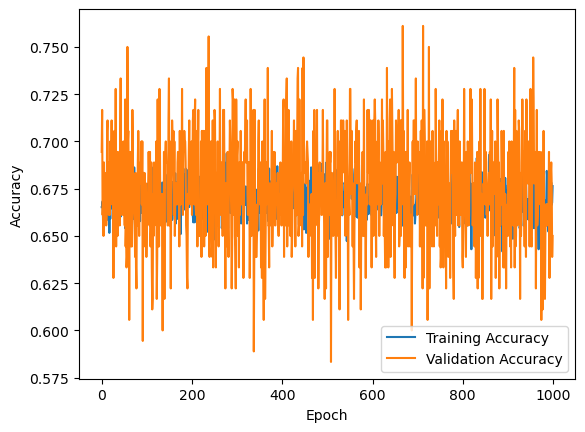

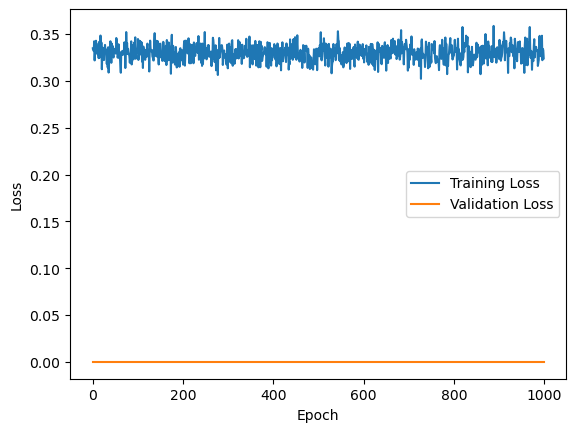

In [12]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# define the model
model = PredictiveCodingNetwork([CustomDense(units=6, activation="sigmoid"),
                                 CustomDense(units=4, activation="sigmoid"), 
                                 CustomDense(units=1, activation="sigmoid")], 
                                vars=[1, 1, 1], # variances. This is super useless and in the code only the last variance is used
                                beta=0.1)

model.build([None, 4704]) 
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-7, weight_decay=1e-2), # wd only when overfitting occurs, lr  
              metrics= ["accuracy"],  
              loss="CategoricalCrossentropy",  # This is just a sham loss we need so model.evaluate doesn't throw an error. We don't use it.
              )

# save model before training
model.save('/Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/final_model_pcn_lr1e-7_untrained.keras') 

# evaluate accuracy and train model
loss, accuracy = model.evaluate(val_dataset.batch(512).map(img_preproc).map(flatten)) 
print(f"Accuracy before training: {accuracy}")


n_epochs = 1000 

train_acc = []
val_acc = []
train_loss = []
val_loss = []
histories = []

for i in range(n_epochs): 
    
    resultspath = f'/Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_{i:02d}_{{accuracy:.2f}}.keras'

    print(f"Epoch {i + 1}/{n_epochs}") 
    
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= resultspath,  
    monitor='accuracy',         # The metric to monitor for saving (e.g., 'val_loss', 'val_accuracy')
    save_best_only=False,        # Save only the best model 
    save_weights_only=False,    # False = Save the entire model; True = only save weights
    mode='max',                 # Set to 'min' for metrics like loss and 'max' for metrics like accuracy
    save_freq='epoch',          # Frequency of saving, e.g., epoch or batch 
    verbose=1                   # Print when saving a model
    )
    
    train_dataset = tf.data.Dataset.from_generator(
        lambda: generate_dataset(img_dir_lead, img_dir_trail, class_names_L, class_names_T, label_dict, image_size = (28,28), seed = i, shuffle = True),
        output_signature=(
            tf.TensorSpec(shape=(56, 28, 3), dtype=tf.float32),  # shape of x 
            tf.TensorSpec(shape=(1), dtype=tf.float32)  # shape of y 
        )
    ) 

    check_transition_balance(train_dataset)
    
    history = model.fit(train_dataset.shuffle(99999).batch(512).map(img_preproc).map(augment_images).map(flatten), 
            validation_data=val_dataset.batch(512).map(img_preproc).map(flatten),
            callbacks=[checkpoint_callback]) 
    
    
    train_acc.extend(history.history['accuracy'])
    val_acc.extend(history.history['val_accuracy'])
    train_loss.extend(history.history['loss'])
    val_loss.extend(history.history['val_loss'])
    
    epoch_history = {
        "epoch": i + 1,
        "history": history.history
    }
    
    histories.append(epoch_history)


    with open('/Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/all_epochs_history.json', 'w') as f:
        json.dump(histories, f)


loss, accuracy = model.evaluate(val_dataset.batch(512).map(img_preproc).map(flatten)) 
print(f"Accuracy after training: {accuracy}")

model.save('/Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/final_model_pcn_lr1e-7_trained.keras')

Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step - accuracy: 0.6278 - loss: 4.4372e-08
Accuracy before training: 0.6277777552604675
Epoch 1/1000
Found 1616 files belonging to 5 classes.


2024-11-01 00:18:56.427088: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/denisekittelmann/miniconda3/envs/BiMo_3.9/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 0.0: 1074 occurrences
Transition 1.0: 542 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 8s 41ms/step - accuracy: 0.6594 - loss: 0.3404Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.


2024-11-01 00:19:07.953850: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_01_0.66.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 194ms/step - accuracy: 0.6600 - loss: 0.3398 - val_accuracy: 0.6500 - val_loss: 4.1723e-08
Epoch 2/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 0.0: 1108 occurrences
Transition 1.0: 508 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 44ms/step - accuracy: 0.6506 - loss: 0.3491Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_01_0.65.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 0.6518 - loss: 0.3479 - val_accuracy: 0.6333 - val_loss: 4.3710e-08
Epoch 3/1000
Found 1616 files belonging to 5 classes.


2024-11-01 00:19:15.864523: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 1.0: 536 occurrences
Transition 0.0: 1080 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 73ms/step - accuracy: 0.6489 - loss: 0.3510Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_01_0.66.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 0.6529 - loss: 0.3469 - val_accuracy: 0.7056 - val_loss: 3.5101e-08
Epoch 4/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 0.0: 1066 occurrences
Transition 1.0: 550 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 63ms/step - accuracy: 0.6888 - loss: 0.3111Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 

2024-11-01 00:19:36.744412: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_01_0.67.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - accuracy: 0.6727 - loss: 0.3273 - val_accuracy: 0.6500 - val_loss: 4.1723e-08
Epoch 6/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 1.0: 535 occurrences
Transition 0.0: 1081 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 73ms/step - accuracy: 0.6693 - loss: 0.3305Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_01_0.66.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 0.6672 - loss: 0.3327 - val_accuracy: 0.6444 - val_loss: 4.2386e-08
Epoch 7/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Tra

2024-11-01 00:20:13.024625: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 1.0: 541 occurrences
Transition 0.0: 1075 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 62ms/step - accuracy: 0.6642 - loss: 0.3355Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_01_0.67.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - accuracy: 0.6646 - loss: 0.3351 - val_accuracy: 0.6667 - val_loss: 3.9736e-08
Epoch 12/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 0.0: 1075 occurrences
Transition 1.0: 541 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 61ms/step - accuracy: 0.6793 - loss: 0.3203Found 180 files belonging to 5 classes.
Found 180 files belonging to 4

2024-11-01 00:21:44.678507: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_01_0.70.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 0.6921 - loss: 0.3078 - val_accuracy: 0.6833 - val_loss: 3.7750e-08
Epoch 22/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 0.0: 1063 occurrences
Transition 1.0: 553 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 61ms/step - accuracy: 0.6610 - loss: 0.3388Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_01_0.65.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step - accuracy: 0.6568 - loss: 0.3431 - val_accuracy: 0.6722 - val_loss: 3.9074e-08
Epoch 23/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
T

2024-11-01 00:24:30.179094: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 1.0: 537 occurrences
Transition 0.0: 1079 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 57ms/step - accuracy: 0.6675 - loss: 0.3324Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_01_0.66.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.6651 - loss: 0.3348 - val_accuracy: 0.7111 - val_loss: 3.4438e-08
Epoch 44/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 1.0: 542 occurrences
Transition 0.0: 1074 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 60ms/step - accuracy: 0.6685 - loss: 0.3309Found 180 files belonging to 5 classes.
Found 180 files belonging to 4

2024-11-01 00:30:03.749159: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_01_0.66.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - accuracy: 0.6563 - loss: 0.3434 - val_accuracy: 0.6667 - val_loss: 3.9736e-08
Epoch 86/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 1.0: 545 occurrences
Transition 0.0: 1071 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 57ms/step - accuracy: 0.6546 - loss: 0.3457Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_01_0.66.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 0.6581 - loss: 0.3421 - val_accuracy: 0.6944 - val_loss: 3.6425e-08
Epoch 87/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
T

2024-11-01 00:40:59.066115: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 171/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 1.0: 536 occurrences
Transition 0.0: 1080 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 59ms/step - accuracy: 0.6800 - loss: 0.3201Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_01_0.67.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - accuracy: 0.6771 - loss: 0.3230 - val_accuracy: 0.6944 - val_loss: 3.6425e-08
Epoch 172/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 0.0: 1073 occurrences
Transition 1.0: 543 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 58ms/step - accuracy: 0.6578 - loss: 0.3424Found 180 fil

2024-11-01 01:02:53.184429: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_01_0.67.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 0.6748 - loss: 0.3250 - val_accuracy: 0.6667 - val_loss: 3.9736e-08
Epoch 342/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 0.0: 1099 occurrences
Transition 1.0: 517 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 60ms/step - accuracy: 0.6644 - loss: 0.3356Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_01_0.67.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 218ms/step - accuracy: 0.6660 - loss: 0.3341 - val_accuracy: 0.6278 - val_loss: 4.4372e-08
Epoch 343/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.

2024-11-01 01:45:45.336340: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 1.0: 525 occurrences
Transition 0.0: 1091 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 64ms/step - accuracy: 0.6622 - loss: 0.3384Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_01_0.66.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step - accuracy: 0.6617 - loss: 0.3389 - val_accuracy: 0.6778 - val_loss: 3.8412e-08
Epoch 684/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 0.0: 1101 occurrences
Transition 1.0: 515 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 59ms/step - accuracy: 0.6528 - loss: 0.3476Found 180 files belonging to 5 classes.
Found 180 files belonging to 

In [ ]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

train the network

In [ ]:
# define the model
model = PredictiveCodingNetwork([CustomDense(units=6, activation="sigmoid"),
                                 CustomDense(units=4, activation="sigmoid"), 
                                 CustomDense(units=1, activation="sigmoid")], 
                                vars=[1, 1, 1], # variances. This is super useless and in the code only the last variance is used
                                beta=0.1)

model.build([None, 4704]) 
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-7, weight_decay=1e-2), # wd only when overfitting occurs, lr  
              metrics= ["accuracy"],  
              loss="CategoricalCrossentropy",  # This is just a sham loss we need so model.evaluate doesn't throw an error. We don't use it.
              )

# save model before training
model.save('/Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/final_model_pcn_lr1e-7_untrained.keras') 

# evaluate accuracy and train model
loss, accuracy = model.evaluate(val_dataset.batch(512).map(img_preproc).map(flatten)) 
print(f"Accuracy before training: {accuracy}")


n_epochs = 1000 

train_acc = []
val_acc = []
train_loss = []
val_loss = []

for i in range(n_epochs): 

    resultspath = f'/Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_{i:02d}_{{accuracy:.2f}}.keras'
    print(f"Epoch {i + 1}/{n_epochs}") 
    train_dataset = tf.data.Dataset.from_generator(
        lambda: generate_dataset(img_dir_lead, img_dir_trail, class_names_L, class_names_T, label_dict, image_size = (28,28), seed = i, shuffle = True),
        output_signature=(
            tf.TensorSpec(shape=(56, 28, 3), dtype=tf.float32),  # shape of x 
            tf.TensorSpec(shape=(1), dtype=tf.float32)  # shape of y 
        )
    ) 

    check_transition_balance(train_dataset)
    
    history = model.fit(train_dataset.shuffle(99999).batch(512).map(img_preproc).map(augment_images).map(flatten), 
            validation_data=val_dataset.batch(512).map(img_preproc).map(flatten),
            callbacks=[checkpoint_callback]) 
    
    
    train_acc.extend(history.history['accuracy'])
    val_acc.extend(history.history['val_accuracy'])
    train_loss.extend(history.history['loss'])
    val_loss.extend(history.history['val_loss'])


loss, accuracy = model.evaluate(val_dataset.batch(512).map(img_preproc).map(flatten)) 
print(f"Accuracy after training: {accuracy}")

model.save('/Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/final_model_pcn_lr1e-7_trained.keras')

Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step - accuracy: 0.6667 - loss: 3.9736e-08
Accuracy before training: 0.6666666865348816
Epoch 1/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 0.0: 1096 occurrences
Transition 1.0: 520 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      4/Unknown 8s 37ms/step - accuracy: 0.6655 - loss: 0.3351Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_01_0.67.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - accuracy: 0.6659 - loss: 0.3347 - val_accuracy: 0.6611 - val_loss: 4.0399e-08
Epoch 2/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 0.0: 1080 occ

2024-11-01 09:29:00.322578: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 362/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 0.0: 1111 occurrences
Transition 1.0: 505 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 64ms/step - accuracy: 0.6452 - loss: 0.3556Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_01_0.66.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.6502 - loss: 0.3505 - val_accuracy: 0.6722 - val_loss: 3.9074e-08
Epoch 363/1000
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 0.0: 1096 occurrences
Transition 1.0: 520 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 63ms/step - accuracy: 0.6852 - loss: 0.3155Found 180 fil

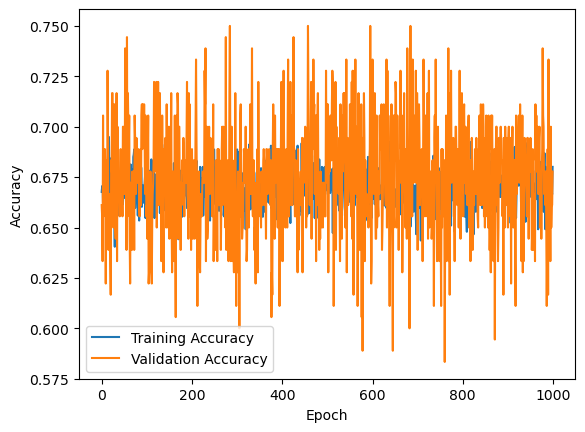

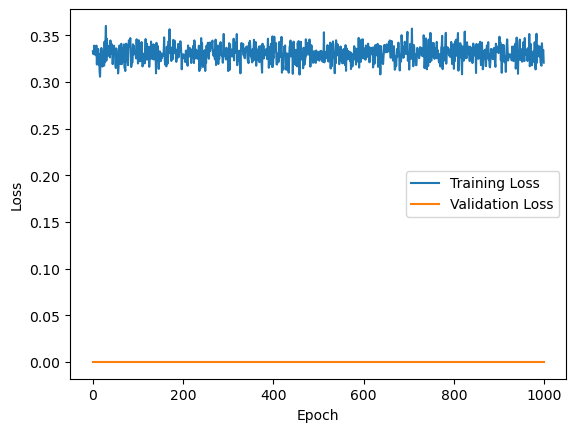

In [37]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

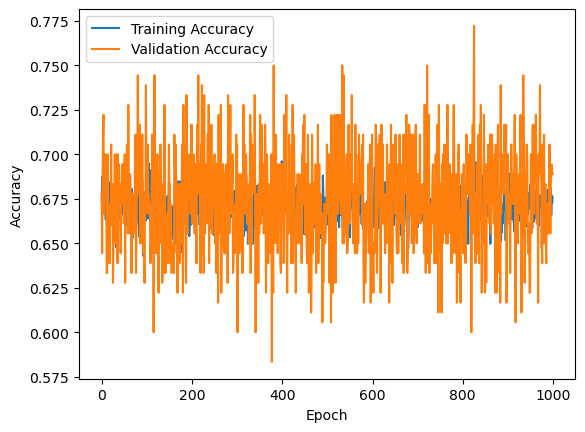

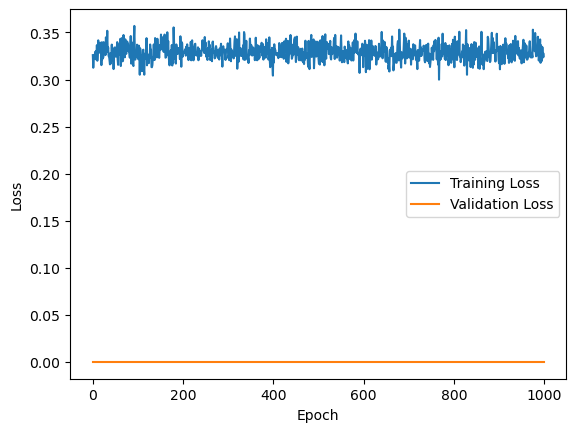

In [ ]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# lr = 1e-7 final 

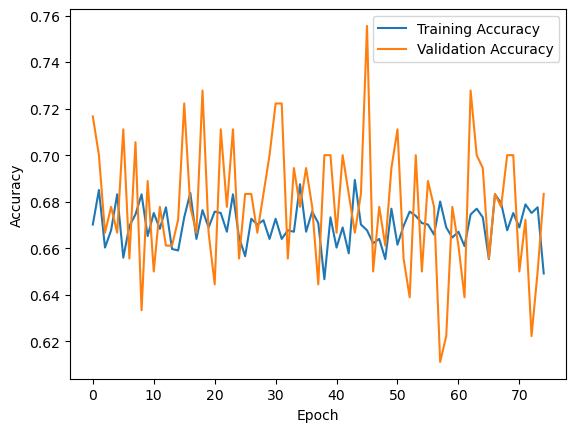

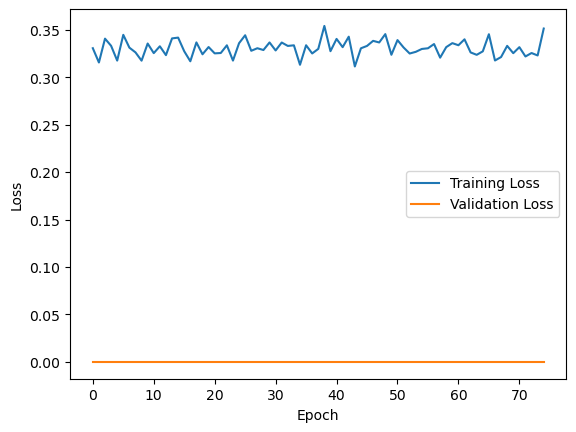

In [ ]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# lr = 1e-7

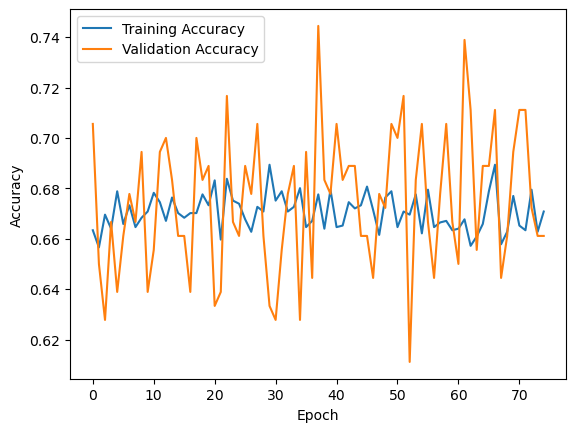

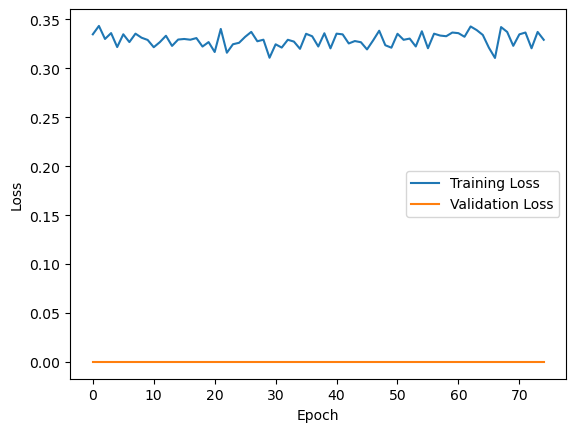

In [ ]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# lr = 1e-3

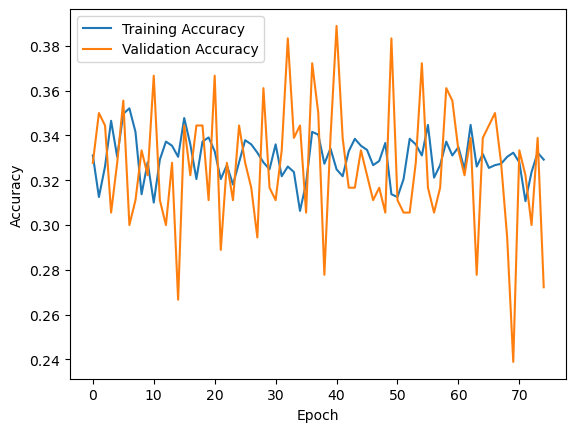

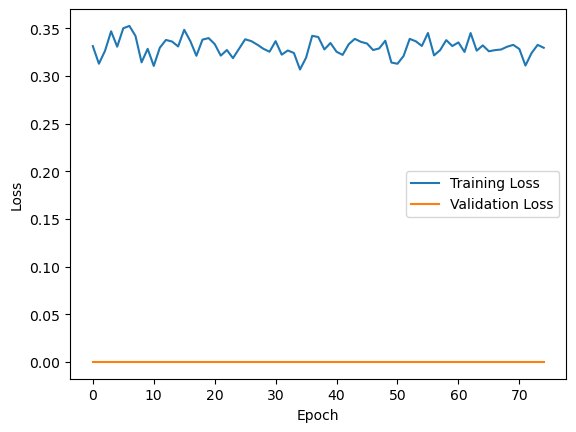

In [ ]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# lr = 1e-5

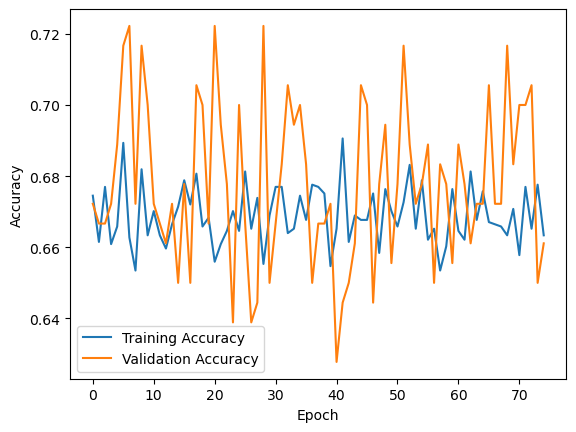

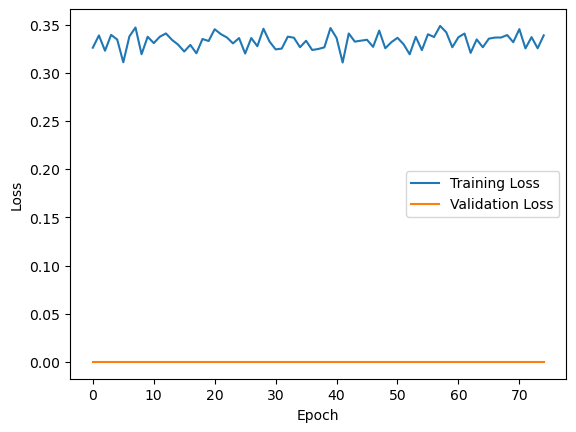

In [ ]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# lr = 1e-5

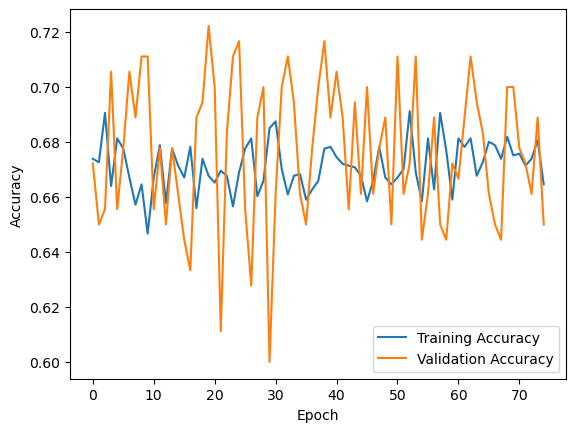

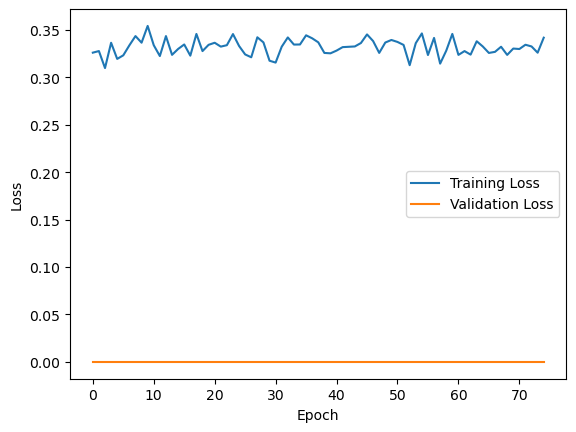

In [ ]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# lr = 1e-4

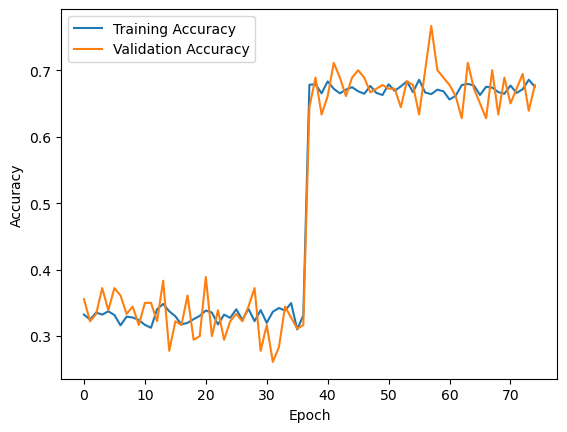

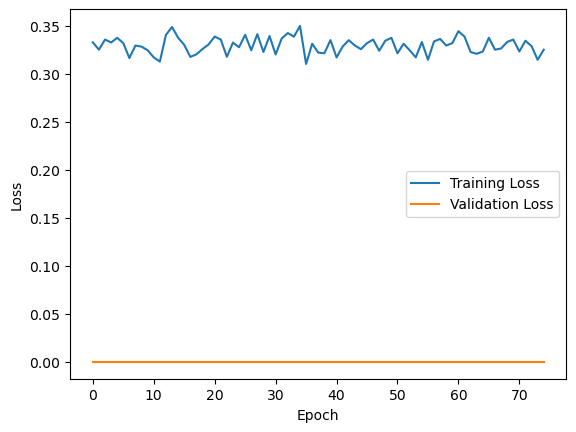

In [ ]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# lr = 1e-3

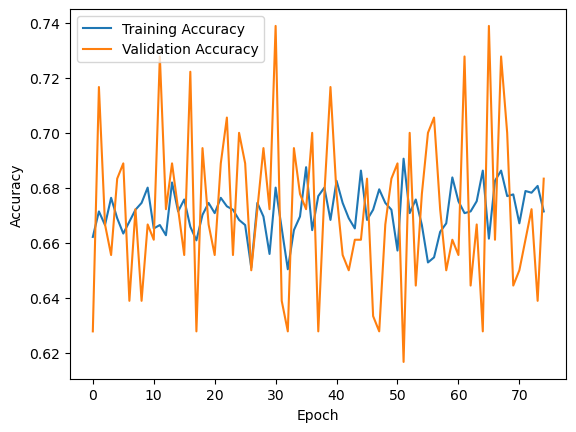

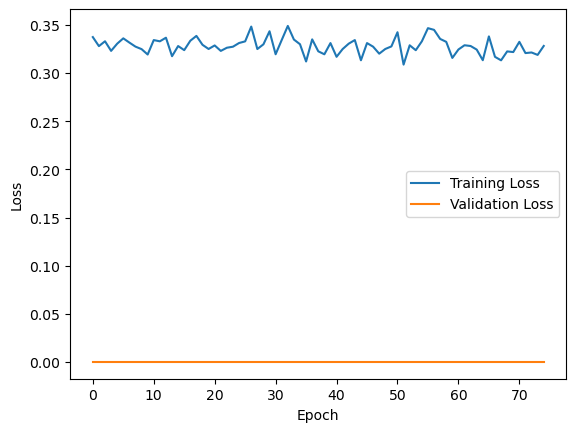

In [ ]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# lr = 1e-7

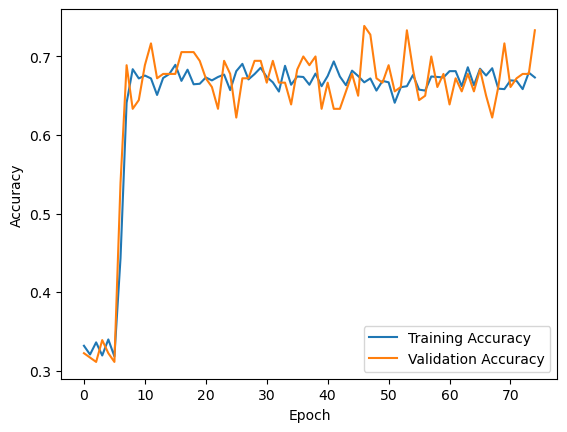

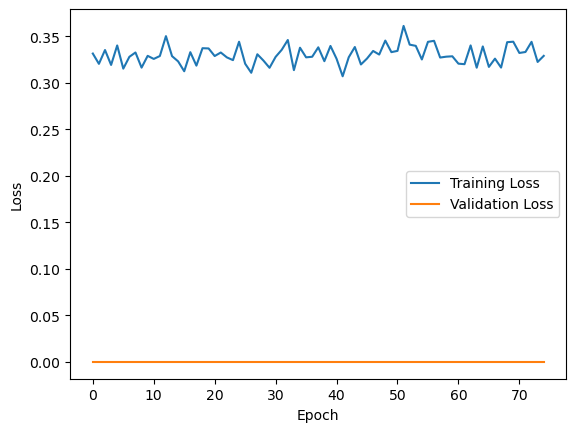

In [ ]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# lr = 1e-5

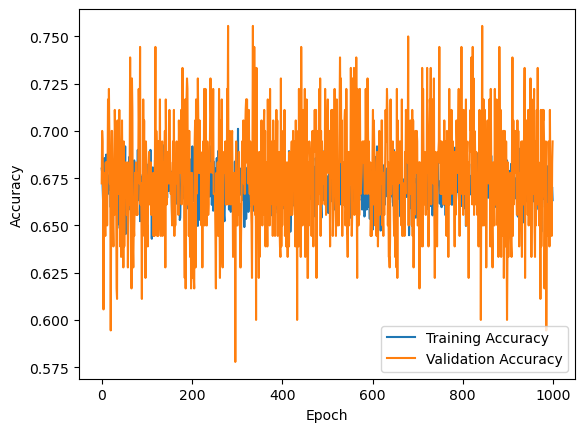

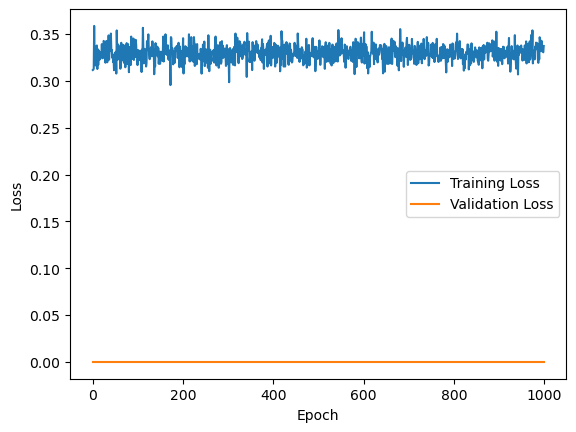

In [ ]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# lr = 1e-5

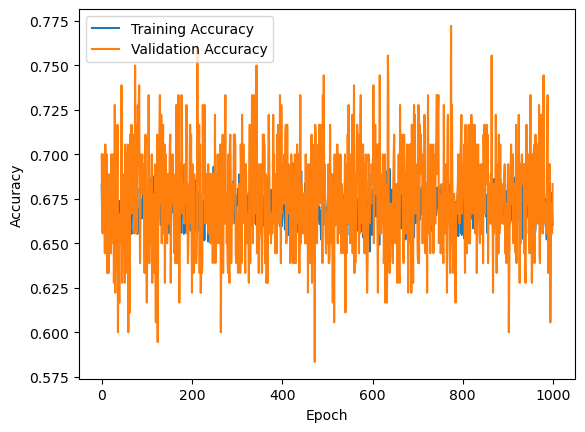

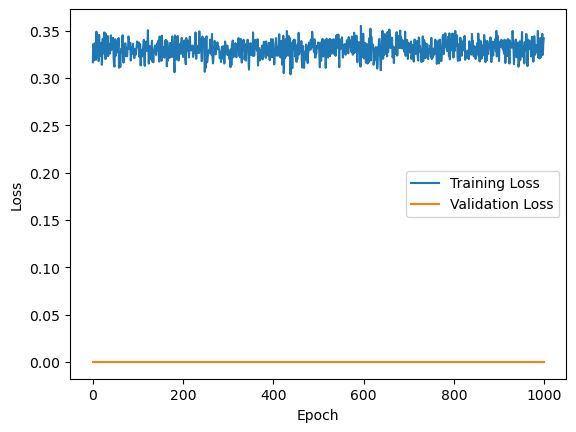

In [ ]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# lr 1e-7

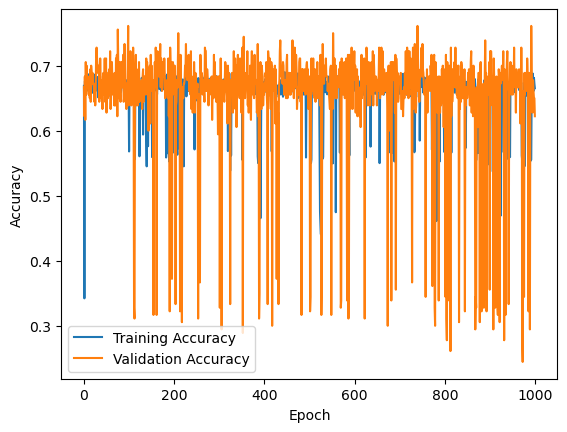

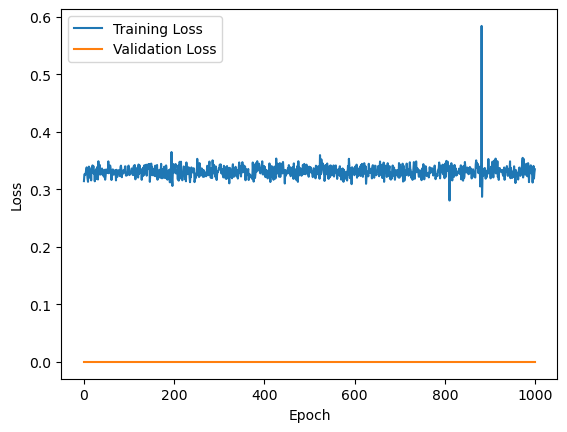

In [ ]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# lr = 1-e3

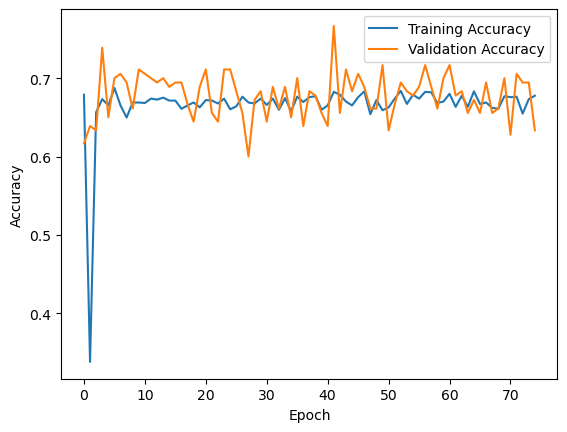

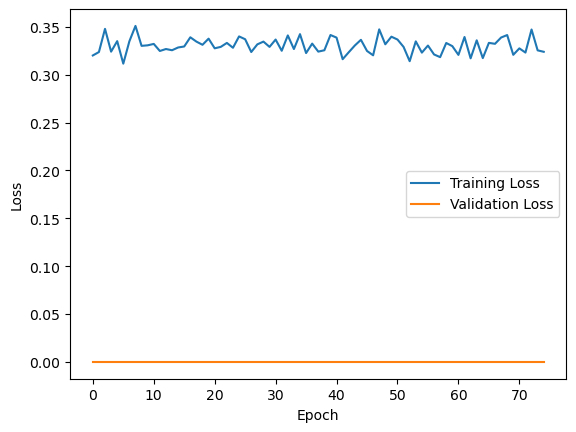

In [ ]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
for x, y in train_dataset.shuffle(99999).batch(32).map(img_preproc).take(1):
    print("x shape:",x.shape)
    print("label y:", y.shape)
    plt.imshow(x[0])